# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.692489,True,6.513994
1,0.647121,True,8.080264
2,-0.291692,True,3.450810
3,1.054548,True,8.130324
4,-0.618836,True,3.947363
...,...,...,...
995,2.401029,True,9.171075
996,1.724637,True,8.373037
997,0.999508,True,7.068687
998,-0.378417,False,1.271395


<Axes: xlabel='v0'>

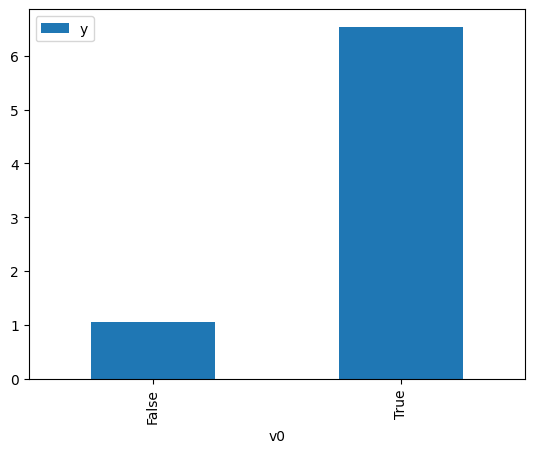

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

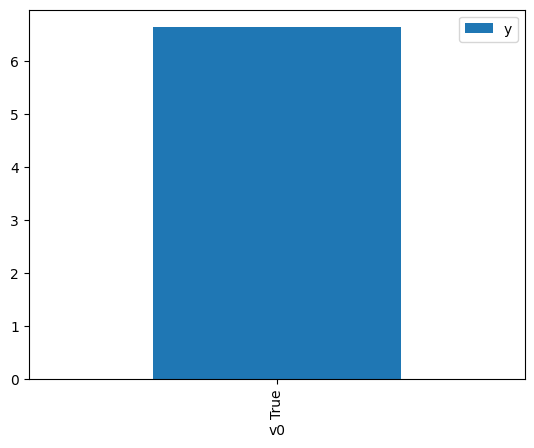

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.232935,False,0.530949,0.070514,14.181545
1,-0.120800,False,-1.078003,0.539004,1.855275
2,0.601958,False,2.265526,0.213499,4.683865
3,0.292528,False,0.574488,0.336535,2.971462
4,1.000027,False,0.634646,0.108299,9.233726
...,...,...,...,...,...
995,1.312027,False,3.808483,0.060733,16.465611
996,0.707995,False,1.570884,0.179726,5.564022
997,0.805173,False,1.552603,0.152575,6.554158
998,0.598637,False,-0.046964,0.214628,4.659231


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.411220,True,5.997172,0.714754,1.399083
1,1.470005,True,7.939459,0.955118,1.046991
2,0.302906,True,6.055634,0.668131,1.496713
3,0.763221,True,5.912023,0.836140,1.195972
4,-0.505381,True,3.969568,0.282244,3.543032
...,...,...,...,...,...
995,0.879454,True,5.608546,0.865835,1.154954
996,2.503162,True,10.771813,0.994207,1.005827
997,2.256445,True,8.361526,0.990499,1.009593
998,1.252414,True,6.828937,0.932022,1.072936


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.808e+04
Date:                Tue, 31 Dec 2024   Prob (F-statistic):                        0.00
Time:                        08:35:02   Log-Likelihood:                         -1451.6
No. Observations:                1000   AIC:                                      2907.
Df Residuals:                     998   BIC:                                      2917.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9217      0.040     48.081      0.000       1.843       2.000
x2             5.0082      0.058     86.916      0.000       4.895       5.121
==============================================================================
Omnibus:                        0.132   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.936   Jarque-Bera (JB):                0.193
Skew:                           0.020   Prob(JB):                        0.908
Kurtosis:                       2.945   Cond. No.                         2.85
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""